**Table of contents**<a id='toc0_'></a>    
- [Обработка данных и Topic Modeling](#toc1_)    
  - [Импорт библиотек](#toc1_1_)    
  - [Профили](#toc1_2_)    
  - [Посты](#toc1_3_)    
  - [Реакции](#toc1_4_)    
  - [Обработка данных](#toc1_5_)    
  - [Лемманизация текста](#toc1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Обработка данных и Topic Modeling](#toc0_)

## <a id='toc1_1_'></a>[Импорт библиотек](#toc0_)

In [1]:
import pandas as pd
import numpy as np
import json
import re

import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem
from wordcloud import WordCloud

import matplotlib.pyplot as plt

from  pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [2]:
from ast import literal_eval

In [3]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Oleg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Зададим random_state

In [6]:
SEED =42

In [19]:
developer_df = pd.read_json('developer_profiles.json')
developer_df.head(3)

,name,city,connections,role,company,experience,employment_type,skills,reactions,posts
nurlan-isbulaev-34bb211a3,Nurlan Isbulaev,Moscow,500+,Backend Developer,Доброзайм,3.92,Full-time,"[JSON, AutoCAD, PHP, Технология строительного ...","[🔥 11 сервисов на базе ИИ ,которые помогут про...","[🔥 11 сервисов на базе ИИ ,которые помогут про..."
maria-terenteva,Maria Terenteva,Moscow,500+,Frontend Developer | Angular,"LLC ""ROBIN""",3.67,Full-time,"[Git, HTML, Отчетность, Ведение переговоров, Д...","[Me being a parent:, Всем привет!Активно ищу р...","[None, None, None, None, None, None, None, Non..."
руслан-гусейнов-091858186,Руслан Гусейнов,Russia,500+,Frontend Developer,OZON.ru,3.67,Full-time,"[Vuex, WebSockets, ООП, git, TypeScript, Gulp,...","[#humor #it, Я #нанимаю. Знаете людей, которых...","[None, None, None, None, None, None, None, Non..."


In [20]:
developer_df['all_posts'] = developer_df['reactions'] + developer_df['posts']

In [21]:
posts_df = pd.read_csv('filtered_posts_df (1).csv')
posts_df

,post_text,reacted_users_info,relevant_users_info,relevant_reactions_count
0,"🎓В EDtech компанию ищем второго дизайнера, кот...",{'https://www.linkedin.com/in/ACoAACWwVPkBv6-7...,{'https://www.linkedin.com/in/ACoAAAMUSTMBzF6i...,2
1,Продолжению открытой менторской сессии “Тимлид...,{'https://www.linkedin.com/in/ACoAAAhdAtwBgdYk...,{},0
2,"Чудесна новина! 😎 ⭐ Natalia Konova M.D., съосн...",{'https://www.linkedin.com/in/ACoAABORW8gBBKOr...,{},0
3,🚀 Are you looking to enter the world of develo...,{'https://www.linkedin.com/in/ACoAAC9nLzEBwQR3...,{},0
4,Learning UX Writing with a Mentor 😎 Are you lo...,{'https://www.linkedin.com/in/ACoAADwvex4ByMeM...,{'https://www.linkedin.com/in/ACoAAC4T7VkBePX_...,2
...,...,...,...,...
537,#отзыв #pitstop #бизнес_тренинг ОТЗЫВ СВЕТЛАН...,{'https://www.linkedin.com/in/ACoAAAJNeXQBhcX7...,{},0
538,"Вы ходите на собеседования, рассказываете о се...",{'https://www.linkedin.com/in/ACoAAAMAhHQBDk2Y...,{},0
539,ОПЫТ + КОУЧИНГ ТВОРИТ ЧУДЕСА🔥Хочу поделиться с...,{'https://www.linkedin.com/in/ACoAABT7hBIBK83R...,{},0
540,Маршалл ГолдсмитБыл у него на тренинге лет 5 н...,{'https://www.linkedin.com/in/ACoAABHz7dkBH-8B...,{},0


## <a id='toc1_5_'></a>[Обработка данных](#toc0_)

- Выгрузка релеввантных постов
- Очистка текстов 
- Лемманизация 
- TF-IDF и LDA

In [22]:
def clean_text(text):
    #import re при использовании pandarallel
    try:
        text = text.lower()
        text = re.sub('[^\w\s]', ' ', text) # удаляем все символы, кроме букв и цифр
        text = re.sub('\d+', '', text) # удаляем все цифры
        
        text = re.sub('[^а-яА-Я\s]+' , '', text)
        text = re.sub('\s+', ' ', text) # заменяем множество пробелов одним пробелом
        
        text = text.strip() # удаляем пробелы в начале и конце текста
    except:
        pass
    return text

<>:5: DeprecationWarning: invalid escape sequence '\w'
<>:6: DeprecationWarning: invalid escape sequence '\d'
<>:8: DeprecationWarning: invalid escape sequence '\s'
<>:9: DeprecationWarning: invalid escape sequence '\s'
<>:5: DeprecationWarning: invalid escape sequence '\w'
<>:6: DeprecationWarning: invalid escape sequence '\d'
<>:8: DeprecationWarning: invalid escape sequence '\s'
<>:9: DeprecationWarning: invalid escape sequence '\s'
C:\Users\Oleg\AppData\Local\Temp\ipykernel_30640\1353664202.py:5: DeprecationWarning: invalid escape sequence '\w'
  text = re.sub('[^\w\s]', ' ', text) # удаляем все символы, кроме букв и цифр
C:\Users\Oleg\AppData\Local\Temp\ipykernel_30640\1353664202.py:6: DeprecationWarning: invalid escape sequence '\d'
  text = re.sub('\d+', '', text) # удаляем все цифры
C:\Users\Oleg\AppData\Local\Temp\ipykernel_30640\1353664202.py:8: DeprecationWarning: invalid escape sequence '\s'
  text = re.sub('[^а-яА-Я\s]+' , '', text)
C:\Users\Oleg\AppData\Local\Temp\ipykern

Объединим все тексты в один список

In [23]:
all_texts = np.concatenate(developer_df['all_posts'].values)

print(all_texts)
print(len(all_texts))

['🔥 11 сервисов на базе ИИ ,которые помогут прокачать твой профиль в LinkedIn🔥❗ Лучшая благодарность за мой труд - это ваши реакции и комментарии!🔥Буду благодарен за подписку на мои другие социальные сети:✔Instagram: instagram.com/ralkofood\xa0Там все о еде, обратная сторона работы ресторанов, рецепты, Food-обзоры, будет много контента о жизни в Польше и Европе в целоми т.д.✔Telegram: t.me/RalkoDenis\xa0Там дублирую весь контент из LinkedIn, что бы вам было удобней читать и ничего не пропускать.📌\xa0jasper.ai/\xa0ИИ-копирайтер. Поможет сгенерировать интересные статьи в LinkedIn\xa0#linkedin📌\xa0wonsulting.com/networkai\xa0Автоматизированный инструмент ИИ, который помогает пользователям быстро и эффективно расширить свою профессиональную сеть.📌\xa0sayhi.pro/\xa0Расширение Chrome на базе ИИ, которое помогает пользователям писать эффективные и убедительные сообщения LinkedIn, адаптированные к их получателям.📌\xa0linkoai.com/\xa0Инструмент на основе ИИ, который помогает людям максимально и

Уберем дубликаты с помощью множества.

In [24]:
all_texts = np.array(list(set(all_texts)))
all_texts

array(['это я сижу в чатах среди разработчиков, читаю их советы друг другу и пытаюсь вычислить, кто из них самый скилловый, чтобы предложить вакансию ',
       'Today, we’re announcing that Airbnb employees can live and work anywhere.',
       'В статье Менеджеры Js/Css библиотек мы рассматривали какие есть варианты использования менеджеров зависимости. В данной статье мы рассмотрим как использовать Component для Symfony2.',
       ...,
       "Alexander Pasko #Kudos You're so great to work with #MakingWorkFun ",
       'Ряд иностранных компаний-разработчиков приняли решение уйти из России.Для нас важно поддержать IT-сообщество в этот сложный момент.Если вы или вся ваша команда оказались в непростой ситуации – мы готовы рассмотреть возможности для вашего перехода в компанию IT_One.Направляйте ваши резюме на career@it-one.ru и мы обязательно с вами свяжемся.#itone #itcareer #itcareers #career #informationtechnology #software #softwaredevelopment #softwareengineer',
       'Молю вас, люд

Очистим текст

In [41]:
all_texts_cleaned = np.vectorize(clean_text)(all_texts)
all_texts_cleaned =  all_texts_cleaned[all_texts_cleaned != ''] 
print(len(all_texts_cleaned))
#all_texts_cleaned

794


In [26]:
posts_df['post_text_cleaned'] = posts_df.post_text.apply(clean_text)
posts_df.head(3)

,post_text,reacted_users_info,relevant_users_info,relevant_reactions_count,post_text_cleaned
0,"🎓В EDtech компанию ищем второго дизайнера, кот...",{'https://www.linkedin.com/in/ACoAACWwVPkBv6-7...,{'https://www.linkedin.com/in/ACoAAAMUSTMBzF6i...,2,в компанию ищем второго дизайнера который гото...
1,Продолжению открытой менторской сессии “Тимлид...,{'https://www.linkedin.com/in/ACoAAAhdAtwBgdYk...,{},0,продолжению открытой менторской сессии тимлид ...
2,"Чудесна новина! 😎 ⭐ Natalia Konova M.D., съосн...",{'https://www.linkedin.com/in/ACoAABORW8gBBKOr...,{},0,чудесна новина съосновател на спечели наградат...


Лемманизирем текст с помощью библиотеки pymystem3

In [27]:
m = Mystem()
def lemmatize(text):
    return "".join(m.lemmatize(text))

In [28]:
%%time
lemmatized_texts = np.vectorize(lemmatize)(all_texts_cleaned)

CPU times: total: 2.67 s
Wall time: 9min 57s


c:\Users\Oleg\anaconda3\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


CPU times: total: 578 ms
Wall time: 578 ms


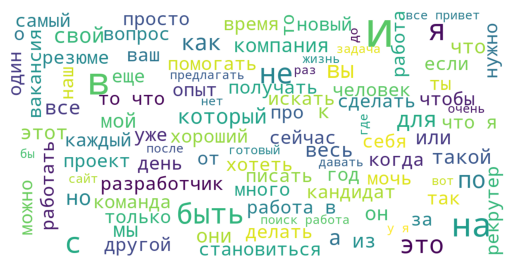

In [29]:
%%time
wordcloud = WordCloud(background_color='white',max_words=100,
                      max_font_size=40,
                      scale=3,
                      random_state=SEED).generate(' '.join(lemmatized_texts))
plt.axis('off')
plt.imshow(wordcloud)

In [30]:
posts_df['post_text_lemma'] = posts_df['post_text_cleaned'].apply(lemmatize)

## Моделирование

Стоп слова

In [31]:
Stop_Words = list(set(stopwords.words('russian')))
Stop_Words.append('это')
#print(stop_words)

In [32]:
tfidf = TfidfVectorizer(stop_words=Stop_Words, min_df=10, max_df=0.9)

In [33]:
X = tfidf.fit_transform(lemmatized_texts)
X

<794x609 sparse matrix of type '<class 'numpy.float64'>'
	with 16764 stored elements in Compressed Sparse Row format>

In [34]:
text_df = pd.DataFrame.sparse.from_spmatrix(X, columns = tfidf.get_feature_names_out())
text_df

,авито,автоматизация,айти,активно,активный,актуальный,аналитик,английский,архитектура,база,...,человек,честно,число,читать,чувствовать,школа,штат,этап,являться,язык
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.267403,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.067485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.428338,...,0.037269,0.0,0.0,0.048925,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.345251,0.0,0.0,0.0,0.0
790,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
791,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
792,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


## LDA

In [35]:
id2word = {i: token for i, token in enumerate(tfidf.get_feature_names_out())}

In [36]:
n_topics = 10
lda = LatentDirichletAllocation(n_components=n_topics, random_state=SEED)
topics = lda.fit_transform(X)
topics.shape

(794, 10)

Ключевые слова для полученных тем

In [37]:
for i in range(n_topics):
    c = lda.components_[i, :]
    topic_tokens = [id2word.get(token_id) for token_id in np.argsort(c)[-20:]]
    print("Тема",i+1, ":")
    print(", ".join(topic_tokens))
    print("\n ")

Тема 1 :
мочь, чувствовать, любить, свой, конец, делать, связь, спасибо, очень, английский, деньги, ответ, приходить, время, смотреть, знакомый, сделать, человек, беларусь, жить

 
Тема 2 :
рекрутер, поиск, возможность, благодарить, хотеть, следующий, получать, проверка, разработчик, проходить, значок, тест, навык, работа, новый, начинать, компания, должность, сообщать, удовольствие

 
Тема 3 :
переезжать, коллега, граница, оказываться, разработчик, день, называть, искать, конец, документ, неделя, почему, человек, нужно, любимый, релокация, целое, думать, вывод, писать

 
Тема 4 :
хороший, обо, готовиться, последний, именно, использовать, ничто, лента, москва, тестирование, удобный, сегодня, скоро, идея, бесплатный, проект, подборка, немного, тестировщик, работать

 
Тема 5 :
красивый, лайк, показывать, ниже, место, разработчик, прочитывать, связь, крупный, начинающий, отдел, тестирование, учить, весь, штат, зп, разработка, искать, очень, привет

 
Тема 6 :
расширять, вакансия, обучени

Типичные тексты

In [38]:
for i in range(n_topics):
    doc_id = np.argmax(topics[:, i])
    print("Тема ", i+1)
    #print(developer_df.iloc[doc_id]["posts"])
    print(all_texts_cleaned[doc_id])
    print("\n")

Тема  1
занимаюсь изучением программирования более лет ищу работу интересную без собесов да именно без этой клоунады на собесах что везде происходит в лице тимлида или руководителя хочу делать реально приносящий пользу или сервис моя работа будет заключаться в том чтобы искать готовые решения делать прототипы продумывать автоматизацию деятельности


Тема  2
здравствуйте я в поиске новой карьерной возможности и буду признателен за вашу поддержку заранее благодарю за все рекомендации контактов советы или возможности которые вы можете предложить текущий стек


Тема  3
сегодня со мной случилось это на меня пожаловался разраб и теперь я могу писать в телеграм только взаимным контактам до конца недели вопрос зачем если не нравится не читай заблокируй но не забирай у других людей рабочий инструмент о наболевшем


Тема  4
в предыдущей статье использование в мы рассматривали как использовать для менеджера зависимостей есть несколько недостатков которые не позволяют нам всегда его использовать р

## LDA постам с темой наставничество

In [39]:
tfidf = TfidfVectorizer(stop_words=Stop_Words, min_df=10, max_df=0.9)
X = tfidf.fit_transform(posts_df['post_text_lemma'])
id2word = {i: token for i, token in enumerate(tfidf.get_feature_names_out())}

n_topics = 10
lda = LatentDirichletAllocation(n_components=n_topics, random_state=SEED)
topics = lda.fit_transform(X)
topics.shape

(542, 10)

In [40]:
for i in range(n_topics):
    c = lda.components_[i, :]
    topic_tokens = [id2word.get(token_id) for token_id in np.argsort(c)[-20:]]
    print("Тема",i+1, ":")
    print(", ".join(topic_tokens))
    print("\n ")

Тема 1 :
теплый, нетворкинг, научать, ов, переговоры, критический, деловой, креативный, недавно, присоединяться, подборка, голова, легко, лидерство, сказать, точно, письмо, хотеться, менторский, мышление

 
Тема 2 :
взгляд, менторство, якщо, сво, робот, мена, ви, ми, досвд, робощать, це, вд, що, благодарность, наставничество, як, ваш, отзыв, благодарить, потрясающийнаставник

 
Тема 3 :
лс, получение, продавать, набирать, право, степень, сертификат, обратный, миллион, приятно, менторство, дорогой, яндекс, подготовить, серия, благодарить, пример, лидерство, наставничество, основатель

 
Тема 4 :
наставничество, бизнес, обучение, хотеть, преподавание, весь, мочь, программа, работать, развитие, новый, человек, команда, проект, год, компания, опыт, который, свой, работа

 
Тема 5 :
якщо, команда, справляться, оно, многое, совместный, увидеть, регион, наш, разбирать, канал, телегр, джуна, работа, информация, ко, проектный, деталь, функция, просить

 
Тема 6 :
связывать, сессия, лидерство, з